In [1]:
from google.colab import drive
drive.mount("/content/MyDrive/")

Mounted at /content/MyDrive/


In [2]:
import os
from PIL import Image
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

#Some looking around not necessary

In [3]:
cd /content/MyDrive/MyDrive/PFE_Deepfakes/datasets/DFDC/splited/test/test_face46/

/content/MyDrive/MyDrive/PFE_Deepfakes/datasets/DFDC/splited/test/test_face46


In [5]:
fakes = os.listdir('fake')

In [6]:
reals = os.listdir('real')

In [7]:
test_im_dir = "/content/MyDrive/MyDrive/PFE_Deepfakes/datasets/DFDC/splited/test/test_face46/"

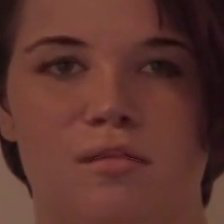

In [8]:
im = Image.open(os.path.join(test_im_dir,"fake",fakes[0]))
im

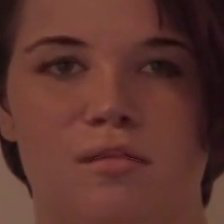

In [29]:
# Resize image to match with input model
im.resize((224, 224))



In [37]:
im_np = numpy.array(im)
im_torch = torch.Tensor(im_np)

In [ ]:
im_torch

In [50]:
imsize = 224
loader = transforms.Compose([transforms.Resize(imsize), transforms.ToTensor()])

def image_loader1(image_name):
    """load image, returns cuda tensor"""
    image = Image.open(image_name)
    image = loader(image).float()
    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return image  #assumes that you're using GPU

image = image_loader1(os.path.join(test_im_dir,"fake",fakes[10]))
image = image_loader1(os.path.join(test_im_dir,"real",reals[10]))

model(image)

tensor([[-17.4653,   8.0081]], grad_fn=<AddmmBackward>)

In [51]:
outputs = model(image)
a, b = torch.max(outputs, 1)
print(a)
print(b)

tensor([8.0081], grad_fn=<MaxBackward0>)
tensor([1])


#Begins here

In [3]:
!pip install einops

In [4]:
cd/content/MyDrive/MyDrive/PFE_Deepfakes/df_code/CViT_main/CViT_main/model/

/content/MyDrive/MyDrive/PFE_Deepfakes/df_code/CViT_main/CViT_main/model


In [5]:
from cvit import CViT

In [6]:
model = CViT(image_size=224, patch_size=7, num_classes=2, channels=512,
            dim=1024, depth=6, heads=8, mlp_dim=2048)

In [7]:
checkpoint_test = torch.load(os.path.join('/content/MyDrive/MyDrive/PFE_Deepfakes/df_code/CViT_main/CViT_main/weight', 'cvit_dfd_epoch_0_batch_5600.pth'))

In [8]:
model.load_state_dict(checkpoint_test['state_dict'])

<All keys matched successfully>

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
model.to(device)

CViT(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

#test

In [14]:
cd/content/MyDrive/MyDrive/PFE_Deepfakes/df_code/CViT_main/CViT_main/helpers/

/content/MyDrive/MyDrive/PFE_Deepfakes/df_code/CViT_main/CViT_main/helpers


In [15]:
from loader import session

In [18]:
batch_size, dataloaders, dataset_sizes = session('g', '/content/MyDrive/MyDrive/PFE_Deepfakes/datasets/DFDC/splited/train_validation_test', 32)

In [19]:
def test(model):
    model.eval()

    Sum = 0
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        output = model(inputs).to(device).float()
        
        _,prediction = torch.max(output,1)
        
        pred_label = labels[prediction]
        pred_label = pred_label.detach().cpu().numpy()
        main_label = labels.detach().cpu().numpy()
        bool_list  = list(map(lambda x, y: x == y, pred_label, main_label))
        Sum += sum(np.array(bool_list)*1)
        
    print('Prediction: ', (Sum/dataset_sizes['test'])*100,'%')

In [20]:
test(model)

Prediction:  51.232977548767025 %
